In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as TF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import random
import OpenEXR
import Imath
import wandb
from IPython.display import clear_output

wandb.login()

True

In [13]:
class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, sample):
        if random.random() < self.p:
            sample = torch.flip(sample, dims=[2])
        return sample
    
class RandomVerticalFlip:
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, sample):
        if random.random() < self.p:
            sample = torch.flip(sample, dims=[1])
        return sample

class RandomRotation:
    def __init__(self, degrees=45, p=0.5):
        self.degrees = degrees
        self.p = p
    
    def __call__(self, sample):
        if random.random() < self.p:
            angle = random.uniform(-self.degrees, self.degrees)
            sample = TF.functional.rotate(sample, angle)
        return sample
    

class HorizontalFlip:
    def __call__(self, sample):
        sample = torch.flip(sample, dims=[2])
        return sample

class VerticalFlip:
    def __call__(self, sample):
        sample = torch.flip(sample, dims=[1])
        return sample

class Rotation:
    def __init__(self, degrees=45):
        self.degrees = degrees
    
    def __call__(self, sample):
        angle = self.degrees
        sample = TF.functional.rotate(sample, angle)

Train size: 300 | Train shape: torch.Size([2, 256, 256])
Validation size: 100 | Validation shape: torch.Size([2, 256, 256])
Test size: 100 | Test shape: torch.Size([2, 256, 256])


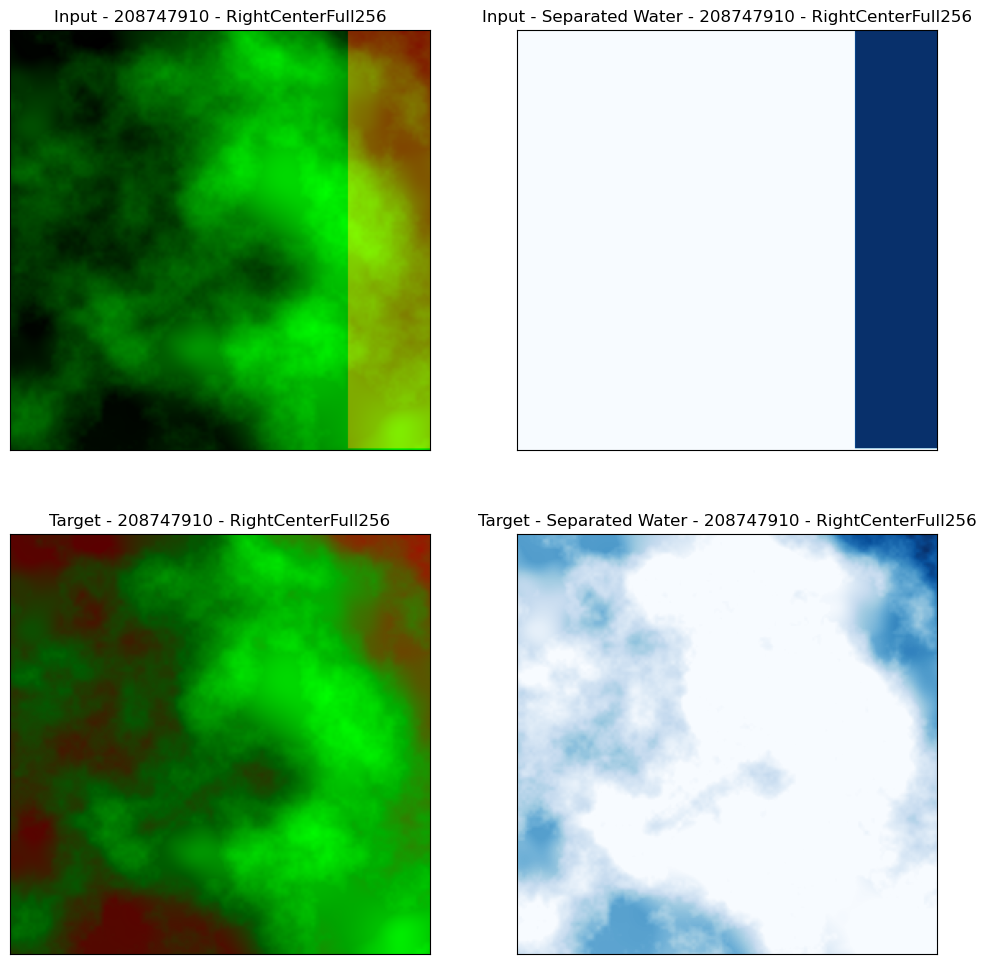

In [14]:
class EXRDataset(Dataset):
    def __init__(self, directories, epsilon=0.01, transform=None):
        self.directories = directories
        self.transform = transform
        self.samples = []
        for directory in self.directories:
            files = sorted([f for f in os.listdir(directory) if f.endswith('.exr')])
            for f in files:
                seed, wave, height = parse_filename(f)
                self.samples.append((directory, f, seed, wave, height))
        if transform is not None:
            print(f'Initializing EXRDataset with transforms')
        
    

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = os.path.join(self.samples[idx][0], self.samples[idx][1])
        # print(f'ID: {idx} - FILE PATH: {file_path}')
        # Load EXR image
        exr_file = OpenEXR.InputFile(file_path)
        dw = exr_file.header()['dataWindow']
        width = dw.max.x - dw.min.x + 1
        height = dw.max.y - dw.min.y + 1
        assert(width == 256 and height == 256)
        
        # Extract channels
        pt = Imath.PixelType(Imath.PixelType.FLOAT)
        input_channels = [np.frombuffer(exr_file.channel(c, pt), dtype=np.float32).reshape(height, width) for c in ['R', 'G']]
        target_channels = [np.frombuffer(exr_file.channel(c, pt), dtype=np.float32).reshape(height, width) for c in ['B', 'A']]
        
        # Stack channels
        input = np.stack(input_channels, axis=0)  # Shape: (2, H, W)
        target = np.stack(target_channels, axis=0)  # Shape: (2, H, W)

        # Convert to tensors
        input = torch.tensor(input, dtype=torch.float32) # Shape: (2, H, W)
        target = torch.tensor(target, dtype=torch.float32)  # Shape: (2, H, W)

        # Subtract epsilon from first target channel to account for simulation's floating point error
        target[0] = target[0] - 0.01

        # Ensure that first channel of target is always 0 or greater
        target[0] = torch.max(target[0], torch.tensor(0.0))

        
        if self.transform:
            combined = torch.cat([input, target], dim=0)  # Shape: (4, H, W)
            combined = self.transform(combined)
            input = combined[:2, :, :]
            target = combined[2:, :, :]
    
        return input, target, idx


# Filenames should all be in the format S_#####_W_wavename_H_averageheight.exr
def parse_filename(filename):
    # print(filename)
    filename = os.path.basename(filename)
    filename = filename[0:-4]
    parts = filename.split('_')
    seed = parts[1]
    wave = parts[3]
    height = 0
    try:
        height = float(parts[5])
    except:
        print(f'Filename weirdness...: {filename}')
    return seed, wave, height


def load_dataset(batch_size, directories, test_split=0.6, val_split=0.2, transform=None, use_validation=True):
    #  get local path
    local_path = os.getcwd()
    concat_directories = []

    assert test_split + val_split < 1.0, f"Test split and validation split must sum to less than 1.0"

    # print(f'Loading local directories: {directories}')
    for i in range(len(directories)):
        concat_directories.append(local_path + directories[i])
    
    # print(f'Concat directories: \n{directories}')


    dataset = EXRDataset(concat_directories, transform=transform)


    # Split dataset into train and validation
    if use_validation:
        train_size = int(test_split * len(dataset))
        val_size = int(val_split * len(dataset))
        test_size = len(dataset) - train_size - val_size
        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Print dataset sizes
        print(f"Train size: {len(train_dataset)} | Train shape: {train_dataset[0][0].shape}")
        print(f"Validation size: {len(val_dataset)} | Validation shape: {val_dataset[0][0].shape}")
        print(f"Test size: {len(test_dataset)} | Test shape: {test_dataset[0][0].shape}")
    
        return train_loader, val_loader, test_loader
    else:
        train_size = int(0.8 * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        print(f"Train size: {len(train_dataset)} | Train shape: {train_dataset[0][0].shape}")
        print(f"Test size: {len(test_dataset)} | Test shape: {test_dataset[0][0].shape}")

        return train_loader, None, test_loader


def load_test_dataset(batch_size, portion=0.9):
    local_path = os.getcwd()

    directories = [local_path + "/data_lidar_a"]

    dataset = EXRDataset(directories)

    test_size = int(portion * len(dataset))
    test_dataset, _ = random_split(dataset, [test_size, len(dataset) - test_size])


    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Test only size: {len(dataset)} | Test shape: {dataset[0][0].shape}")

    return test_loader


#  input tensor shape: (2, H, W)
def convert_to_rgb(input):
    # print(input.shape)
    tmp = input.squeeze(0)  # Shape: (2, H, W)
    # print(tmp.shape)
    H,W = tmp.shape[1], tmp.shape[2]
    rgb_input = torch.zeros((H,W,3))
    rgb_input[:,:,0] = tmp[0]
    rgb_input[:,:,1] = tmp[1]

    return rgb_input


def verify_dataset():
    batch_size = 256
    tr_loader, va_loader, te_loader = load_dataset(batch_size, directories=["/data_noise_b"])
    tr_inputs, tr_targets, idxs = next(iter(tr_loader))

    # Get the first image in the batch
    input = tr_inputs[0].squeeze(0).numpy()  # Shape: (2, H, W)
    target = tr_targets[0].squeeze(0).numpy()  # Shape: (2, H, W)
    
    dataset = tr_loader.dataset.dataset

    directory, file, seed, wave, height = dataset.samples[idxs[0]]
    
    input = convert_to_rgb(tr_inputs[0].squeeze(0))
    target = convert_to_rgb(tr_targets[0].squeeze(0))

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0,0].imshow(input, cmap='Blues')
    axs[0,0].set_title(f'Input - {seed} - {wave}')
    axs[0,0].set_xticks([])
    axs[0,0].set_yticks([])

    axs[0,1].imshow(tr_inputs[0][0], cmap='Blues')
    axs[0,1].set_title(f'Input - Separated Water - {seed} - {wave}')
    axs[0,1].set_xticks([])
    axs[0,1].set_yticks([])

    axs[1,0].imshow(target, cmap='gray')
    axs[1,0].set_title(f'Target - {seed} - {wave}')
    axs[1,0].set_xticks([])
    axs[1,0].set_yticks([])

    axs[1,1].imshow(tr_targets[0][0], cmap='Blues')
    axs[1,1].set_title(f'Target - Separated Water - {seed} - {wave}')
    axs[1,1].set_xticks([])
    axs[1,1].set_yticks([])
    plt.show()
    


verify_dataset()

In [15]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder: Downsampling Path
        self.enc1 = self.conv_block(2, 16)
        self.enc2 = self.conv_block(16, 32)
        self.enc3 = self.conv_block(32, 64)
        self.enc4 = self.conv_block(64, 128)

        # Bottleneck
        self.bottleneck = self.conv_block(128, 256)

        # Decoder: Upsampling Path
        self.up4 = self.upconv_block(256, 128)
        self.dec4 = self.conv_block(256, 128)

        self.up3 = self.upconv_block(128, 64)
        self.dec3 = self.conv_block(128, 64)

        self.up2 = self.upconv_block(64, 32)
        self.dec2 = self.conv_block(64, 32)

        self.up1 = self.upconv_block(32, 16)
        self.dec1 = self.conv_block(32, 16)

        # Final Output Layer
        self.final = nn.Conv2d(16, 2, kernel_size=1)

    def conv_block(self, in_channels, out_channels, kernel_size=3, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels, kernel_size=2, stride=2):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)                                    # Output: (batch_size, 16, 256, 256)
        enc2 = self.enc2(nn.MaxPool2d(2)(enc1))                # Output: (batch_size, 32, 128, 128)
        enc3 = self.enc3(nn.MaxPool2d(2)(enc2))                # Output: (batch_size, 64, 64, 64)
        enc4 = self.enc4(nn.MaxPool2d(2)(enc3))                # Output: (batch_size, 128, 32, 32)

        # Bottleneck
        bottleneck = self.bottleneck(nn.MaxPool2d(2)(enc4))    # Output: (batch_size, 256, 16, 16)

        # Decoder with Skip Connections
        up4 = self.up4(bottleneck)                             # Output: (batch_size, 128, 32, 32)
        dec4 = self.dec4(torch.cat((up4, enc4), dim=1))        # Concatenate along channels

        up3 = self.up3(dec4)                                   # Output: (batch_size, 64, 64, 64)
        dec3 = self.dec3(torch.cat((up3, enc3), dim=1))        # Concatenate along channels

        up2 = self.up2(dec3)                                   # Output: (batch_size, 32, 128, 128)
        dec2 = self.dec2(torch.cat((up2, enc2), dim=1))        # Concatenate along channels

        up1 = self.up1(dec2)                                   # Output: (batch_size, 16, 256, 256)
        dec1 = self.dec1(torch.cat((up1, enc1), dim=1))        # Concatenate along channels

        # Final Layer
        output = self.final(dec1)                              # Output: (batch_size, 2, 256, 256)
        output = torch.sigmoid(output)                         # Apply Sigmoid activation to get output in [0, 1]
        return output


class DepthMSELoss(nn.Module):
    def __init__(self):
        super(DepthMSELoss, self).__init__()

    def forward(self, predictions, targets):
        # Extract water depth channels
        predicted_depths = predictions[:, :1, :, :]
        target_depths = targets[:, :1, :, :]
        
        # Calculate MSE loss
        loss = F.mse_loss(predicted_depths, target_depths)
        return loss


In [16]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [17]:
def evaluate_model(device, model, loader, criterion, config):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    relative_val_acc = 0.0
    absolute_val_acc = 0.0
    with torch.no_grad():  # No gradients needed
        for inputs, targets, idx in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Extract water depth channels
            predicted_depths = outputs[:, :1, :, :]
            target_depths = targets[:, :1, :, :]

            # Calculate accuracy
            diff = torch.abs(predicted_depths - target_depths)

            relative_accuracy_thresholds = (target_depths * config['rel_accuracy_threshold'])
            relative_accurate_predictions = (diff < relative_accuracy_thresholds).float()
            relative_val_acc += (torch.sum(relative_accurate_predictions) / (256 * 256 * outputs.shape[0])).item()

            absolute_accuracy_predictions = (diff < config['abs_accuracy_threshold']).float()
            absolute_val_acc += (torch.sum(absolute_accuracy_predictions) / (256 * 256 * outputs.shape[0])).item()

            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss = val_loss / len(loader)
    relative_val_acc /= (len(loader))
    absolute_val_acc /= (len(loader))
    return val_loss, absolute_val_acc, relative_val_acc


def train_model(device, model, train_loader, val_loader, optimizer, config, run, real_world_val_loader=None):

    early_stopping = EarlyStopping(config['patience'], config['min_delta'])
    count = 0

    if config['lr_scheduler'] is not None:
        scheduler = config['lr_scheduler']
        scheduler = scheduler(optimizer, **config['scheduler_params'])
    
    for epoch in range(config['n_epochs']):
        count += 1
        #  reset each epoch
        train_loss = 0.0
        relative_train_acc = 0.0
        absolute_train_acc = 0.0

        for inputs, targets, idx in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            model.train()
            outputs = model(inputs)
            loss = config['criterion'](outputs, targets)
            
            # Extract water depth channels
            predicted_depths = outputs[:, :1, :, :]
            target_depths = targets[:, :1, :, :]

            # Calculate accuracy
            # Calculate accuracy
            diff = torch.abs(predicted_depths - target_depths)

            relative_accuracy_thresholds = (target_depths * config['rel_accuracy_threshold'])
            relative_accurate_predictions = (diff < relative_accuracy_thresholds).float()
            relative_train_acc += (torch.sum(relative_accurate_predictions) / (256 * 256 * outputs.shape[0])).item()

            absolute_accuracy_predictions = (diff < config['abs_accuracy_threshold']).float()
            absolute_train_acc += (torch.sum(absolute_accuracy_predictions) / (256 * 256 * outputs.shape[0])).item()

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()


        relative_train_acc /= len(train_loader)
        absolute_train_acc /= len(train_loader)

        if config['use_validation']:
            val_loss, abs_val_acc, rel_val_acc = evaluate_model(device, model, val_loader, config['criterion'], config)
            if config['lr_scheduler'] is not None:
                scheduler.step(val_loss)
            
        if(run!=None):
            run.log({"train_loss": train_loss/len(train_loader), 
                     "absolute_train_accuracy": absolute_train_acc,
                     "relative_train_accuracy": relative_train_acc,
                     "val_loss": val_loss, 
                     "absolute_val_accuracy": abs_val_acc,
                     "relative_val_accuracy": rel_val_acc})
            if real_world_val_loader is not None:
                real_world_val_loss, abs_real_world_val_acc, rel_real_world_val_acc = evaluate_model(device, model, real_world_val_loader, config['criterion'], config)
                run.log({"real_world_val_loss": real_world_val_loss, 
                         "real_world_absolute_val_accuracy": abs_real_world_val_acc,
                         "real_world_relative_val_accuracy": rel_real_world_val_acc})
            
        

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f'Early stopping at epoch: {count}')
            break
    

    
    




In [18]:
# Plots 2x2 plot of predicted and target images, with and without water separation
def plot_comb_sep_water(fig, axs, output, target, outputs, targets, seed, wave, idx, offset=0, nrows=2, ncols=2, prefix=''):
    depths_out = outputs[:,:1,:,:]
    depths_targ = targets[:,:1,:,:]
    depth_max = max(torch.max(depths_out).item(), torch.max(depths_targ).item())
    vmax = depth_max
    vmax = 1.0

    # Predicted image
    norm = mcolors.Normalize(vmin=0, vmax=vmax)
    axs[0 + offset, 0].imshow(output, cmap='Blues')
    axs[0 + offset, 0].set_title(f'{prefix}Predicted Image\n{seed} - {wave}')
    axs[0 + offset, 0].set_xticks([])
    axs[0 + offset, 0].set_yticks([])

    # Predicted - Separated Water
    im_pred = axs[0 + offset, 1].imshow(outputs[idx][0].squeeze(0).cpu(), cmap='Blues', norm=norm)
    divider = make_axes_locatable(axs[0 + offset, 1])
    cax = divider.append_axes("right", size="5%", pad="1%")
    fig.colorbar(im_pred, cax=cax)
    axs[0 + offset, 1].set_title(f'{prefix}Predicted - Water Depth\n{seed} - {wave}')
    axs[0 + offset, 1].set_xticks([])
    axs[0 + offset, 1].set_yticks([])
    
    # Target image
    axs[1 + offset, 0].imshow(target, cmap='gray')
    axs[1 + offset, 0].set_title(f'{prefix}Target Image\n{seed} - {wave}')
    axs[1 + offset, 0].set_xticks([])
    axs[1 + offset, 0].set_yticks([])

    # Target - Separated Water
    im_targ = axs[1 + offset, 1].imshow(targets[idx][0].squeeze(0).cpu(), cmap='Blues', norm=norm)
    divider = make_axes_locatable(axs[1 + offset, 1])
    cax = divider.append_axes("right", size="5%", pad="1%")
    fig.colorbar(im_targ, cax=cax)
    axs[1 + offset, 1].set_title(f'{prefix}Target - Water Depth\n{seed} - {wave}')
    axs[1 + offset, 1].set_xticks([])
    axs[1 + offset, 1].set_yticks([])
    
    # Difference Heat map first row 3rd column
    difference = torch.abs(targets[idx] - outputs[idx]).squeeze(0).cpu()
    difference = difference * difference
    vmax = torch.max(difference).item()
    norm = mcolors.Normalize(vmin=0, vmax=vmax)
    im_diff = axs[0 + offset, 2].imshow(difference[0], cmap='viridis', norm=norm)
    divider = make_axes_locatable(axs[0 + offset, 2])
    cax = divider.append_axes("right", size="5%", pad="1%")
    fig.colorbar(im_diff, cax=cax)
    axs[0 + offset, 2].set_title(f'{prefix}Water Depth L2\n{seed} - {wave}')
    axs[0 + offset, 2].set_xticks([])
    axs[0 + offset, 2].set_yticks([])

    # Percent difference heat map second row 3rd column
    epsilon = 1e-8
    ones = torch.ones_like(targets[idx])
    percent_diff = ((((targets[idx] - (torch.abs(targets[idx] - outputs[idx]))) / (targets[idx] + epsilon)))).squeeze(0).cpu()
    # percent_diff = (torch.abs(targets[idx] - outputs[idx]) / (targets[idx] + epsilon)).squeeze(0).cpu()

    # vmax = torch.max(percent_diff[0]).item()
    vmax = 1.0
    norm = mcolors.Normalize(vmin=0, vmax=vmax)
    im_diff_p = axs[1 + offset, 2].imshow(percent_diff[0], cmap='viridis', norm=norm)
    divider = make_axes_locatable(axs[1 + offset, 2])
    cax = divider.append_axes("right", size="5%", pad="1%")
    fig.colorbar(im_diff_p, cax=cax)
    axs[1 + offset, 2].set_title(f'{prefix}Water Depth Similarity Map\n{seed} - {wave}')
    axs[1 + offset, 2].set_xticks([])
    axs[1 + offset, 2].set_yticks([])
    

# Plots heatmap of depth difference
def plot_difference_heatmap(difference, seed, wave, vmax=0.5):
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    vmax = torch.max(difference).item()
    norm = mcolors.Normalize(vmin=0, vmax=vmax)
    im_diff = axs.imshow(difference[0], cmap='viridis', norm=norm)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad="1%")
    fig.colorbar(im_diff, cax=cax)
    axs.set_title(f'Depth Difference Map - {seed} - {wave}')
    axs.set_xticks([])
    axs.set_yticks([])
    plt.show()

# Plots an instance of each wave type in the test set if plot_all=True, or all instances in the classes_to_plot list
def plot_actual_vs_predicted(device, model, loader, classes_to_plot=['BottomCenterFull256', 'CenterSquareFull256'], plot_all=False, plot_one_random=False, title=''):
    model.eval()
    # Gets the first image of each wave type in the test set, kind of messy but it works
    ####################################################################################################
    directories, files, seeds, waves, heights = [], [], [], [], []
    
    # Ensure that loader's do not transform the data as we access predictions/outputs directly and separately
    
    loader.dataset.dataset.transform = None

    for sample in loader.dataset.dataset.samples:
        directory, file, seed, wave, height = sample
        directories.append(directory)
        files.append(file)
        seeds.append(seed)
        waves.append(wave)
        heights.append(height)

    classes_dict = {}
    indices = []

    waves_set = set(waves)
    for wave in waves_set:
        classes_dict[wave] = None
    
    # Populate classes_dict with indices of each wave type
    for inputs, targets, idxs in loader:
        for id in idxs:
            wave = waves[id]
            if classes_dict[wave] is None:
                classes_dict[wave] = id.item()
    
    # Create tensors for inputs and targets
    inputs, targets = torch.zeros(size=(10, 2, 256, 256)), torch.zeros(size=(10, 2, 256, 256))

    count = 0
    for wave in classes_dict:
        if classes_dict[wave] is not None:
            inputs[count] = loader.dataset.dataset[classes_dict[wave]][0]
            targets[count] = loader.dataset.dataset[classes_dict[wave]][1]
            # plt.imshow(targets[count][0].squeeze(0).cpu())
            # plt.show()
            indices.append(loader.dataset.dataset[classes_dict[wave]][2])
            count += 1
        else:
            AssertionError(f'{wave} not found in test loader dataset')

    ###############################################################################################

    # Predicts inputs from above/plots based on function params
    with torch.no_grad():
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        rand_idx = 0
        nrows = 2
        ncols = 3
        counter = 0
        
        if plot_all:
            nrows = 20
        elif plot_one_random:
            rand_idx = random.randint(0, len(inputs)-1)
        else:
            nrows = len(classes_to_plot) * 2
        
        plot_height = 6 * nrows
        plot_width = 6 * ncols

        fig, axs = plt.subplots(nrows, ncols, figsize=(plot_width, plot_height))
        # fig.tight_layout()
        fig.suptitle(title, y=1.00)
        # print(f'Plotting {nrows}x{ncols} plot')

        for i in range(len(inputs)):
            target = targets[i].squeeze(0).cpu()  # Shape: (2, H, W)
            output = outputs[i].squeeze(0).cpu()  # Shape: (2, H, W)
            target = convert_to_rgb(target)
            output = convert_to_rgb(output)

            difference = torch.abs(targets[i] - outputs[i]).squeeze(0).cpu()
            directory, file, seed, wave, height = loader.dataset.dataset.samples[indices[i]]

            if plot_one_random and (i == rand_idx):
                # print(f'Plotting one random image: {seed} - {wave}')
                plot_comb_sep_water(fig, axs, output, target, outputs, targets, seed, wave, i, nrows=nrows, ncols=ncols, offset=counter)
            elif plot_all:
                # print(f'Plotting all images')
                plot_comb_sep_water(fig, axs, output, target, outputs, targets, seed, wave, i, nrows=nrows, ncols=ncols, offset=counter)
                counter += 2
            elif (wave in classes_to_plot) and (plot_all == False) and (plot_one_random == False):
                # print(f'Plotting from classes_to_plot list {wave} image')
                plot_comb_sep_water(fig, axs, output, target, outputs, targets, seed, wave, i, nrows=nrows, ncols=ncols, offset=counter)
                counter += 2
        plt.show()





**Overview**

- **Configuration Functions**:
  - `get_default_config()`: Returns a default dictionary of training parameters.
  - `create_new_config(...)`: Creates a new configuration dictionary with custom parameters.
  - `get_random_x_classes(x)`: Selects a random subset of classes for plotting.

  - **Configuration Notes**:
  - `accuracy_threshold`: How close in percentage a pred pixel has to be to target pixel in order to be considered "accurate". Ie: 0.1 = 10%

- **Experiment Function**:
  - `experiment(default_config)`: Trains the model using the specified configuration, plots training and validation metrics, evaluates the model on test data, and visualizes predictions.


In [ ]:


def create_new_config(model='UNet', 
                      batch_size=16, n_epochs=100, learning_rate=0.002, 
                      criterion=nn.MSELoss(), 
                      weight_decay=0.01, 
                      classes_to_plot=[], 
                      train_directories=['/data_noise_a', '/data_noise_b', '/data_noise_c'],
                      plot_all=False, plot_one_random=False, transforms=None, plot_training=False, 
                      use_validation=True, model_name='', patience=5, min_delta=0.00001,
                      rel_accuracy_threshold=0.01, abs_accuracy_threshold=0.01, lr_scheduler=None,
                      scheduler_params={'mode': 'min', 'factor': 0.1, 'patience': 5, 'min_lr': 1e-6},
                      test_split=0.6, val_split=0.2):
    new_config = {
        'model': model,
        'batch_size': batch_size,
        'n_epochs': n_epochs,
        'learning_rate': learning_rate,
        'criterion': criterion,
        'weight_decay': weight_decay,
        'classes_to_plot': classes_to_plot,
        'train_directories': train_directories,
        'plot_all': plot_all,
        'plot_one_random': plot_one_random,
        'transforms': transforms,
        'plot_training': plot_training,
        'use_validation': use_validation,
        'model_name': model_name,
        'patience': patience,
        'min_delta': min_delta,
        'rel_accuracy_threshold': rel_accuracy_threshold,
        'abs_accuracy_threshold': abs_accuracy_threshold,
        'lr_scheduler': lr_scheduler,
        'scheduler_params': scheduler_params,
        'test_split': test_split,
        'val_split': val_split
    }

    new_config = new_config.copy()
    return new_config



def get_random_x_classes(x):
    classes = ['BottomCenterFull256', 'BottomCenterHalf256', 'CenterSquareFull256','CenterSquareHalf256', 'LeftCenterFull256', 
               'LeftCenterHalf256', 'RightCenterFull256', 'RightCenterHalf256', 'TopCenterFull256', 'TopCenterHalf256']
    return random.sample(classes, x)


def experiment(configs, run_name='default', use_wand=True, wandb_project='shallow water prediction final', wandb_tags=[], group=None, job_type='train', use_realworld_validation=False):
    #  If only one config, make it a list
    if type(configs) is not list:
        configs = [configs]
    
    
    #  Initialize values, remain None if not used
    run = None
    real_world_val_loader = None


    #  Manage wandb tags ##################################################

    sched_name = 'None'
    transform_names=[]
    criterion_name = configs[0]['criterion'].__class__.__name__
    wandb_tags.append(criterion_name)
    scheduler_params_str = ''

    #  Ensure tags are unique/added
    for config in configs:
        for path in config['train_directories']:
            if not path in wandb_tags:
                wandb_tags.append(path)
        if config['lr_scheduler'] is not None:
            if not config['lr_scheduler'] in wandb_tags:
                wandb_tags.append(config['lr_scheduler'].__class__.__name__)
        if config['transforms'] is not None:
            tmp_transforms = [str(t) for t in config['transforms']]
            for t in tmp_transforms:
                if not t in transform_names:
                    transform_names.append(t)
                if not t in wandb_tags:
                    wandb_tags.append(t)
        
    if config['lr_scheduler'] is not None:
        sched_name = config['lr_scheduler'].__name__
        
    
    for key, value in config['scheduler_params'].items():
        scheduler_params_str += f'{key}:{value}_'
    
    ########################################################################
    
    
    if use_wand:
        run = wandb.init(group=group, tags=wandb_tags,project=wandb_project, job_type=job_type, name=run_name,

        config = {
            'name': run_name,
            'architecture': 'UNet',
            'batch_size': configs[0]['batch_size'],
            'learning_rate': configs[0]['learning_rate'],
            'criterion': criterion_name,
            'weight_decay': configs[0]['weight_decay'],
            'patience': configs[0]['patience'],
            'min_delta': configs[0]['min_delta'],
            'lr_scheduler': sched_name,
            'weight_decay': configs[0]['weight_decay'],
            'scheduler_params': configs[0]['scheduler_params'],
            'transforms': transform_names,
            'test_split': configs[0]['test_split'],
            'val_split': configs[0]['val_split'],
                }
        )


    # Model and training runs
    model = UNet()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    model.to(device)

    # Load realworld test data set
    real_world_test_loader = load_test_dataset(1)

    # optionally load real world validation set to track performance across epochs
    if use_realworld_validation:
        real_world_val_loader = load_test_dataset(1)


    for config in configs:
        print(f'Directories: {config["train_directories"]}')
        train_loader, val_loader, test_loader = load_dataset(config['batch_size'],config['train_directories'], transform=config['transforms'], use_validation=config['use_validation'], test_split=config['test_split'], val_split=config['val_split'])
        
        optimizer = optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
        
        # Training loop
        if config['use_validation']:
            print(f'Training {config["model_name"]} with validation split')
            train_model(device, model, train_loader, val_loader, optimizer, config, run, real_world_val_loader)
        else:
            print(f'Training {config["model_name"]} without validation split')
            train_model(device, model, train_loader, val_loader, optimizer, config, run, real_world_val_loader)
        
        test_loss, abs_test_acc, rel_test_acc = evaluate_model(device, model, test_loader, config['criterion'], config)
        print(f'Test Loss: {test_loss:.8f}, Abs Test Accuracy: {abs_test_acc:.8f}, Rel Test Accuracy: {rel_test_acc:.8f}')

        real_world_test_loss, real_world_abs_test_acc, rel_test_acc = evaluate_model(device, model, real_world_test_loader, config['criterion'], config)
        print(f'Real World Test Loss: {real_world_test_loss:.8f}, Real World Abs Test Accuracy: {real_world_abs_test_acc:.8f}, Real World Rel Test Accuracy: {rel_test_acc:.8f}')

        if run!=None:
            run.log({"test_loss": test_loss, 
                     "real_world_test_loss": real_world_test_loss, 
                     "test_abs_accuracy": abs_test_acc, 
                     "test_rel_accuracy": rel_test_acc,
                     "real_world_abs_test_accuracy": real_world_abs_test_acc,
                     "real_world_rel_test_accuracy": rel_test_acc
                     })
        
        if config['plot_all'] == False and config['plot_one_random'] == False and len(config['classes_to_plot']) == 0:
            pass
        else:
            suptitle = f'{config["model_name"]}\nLR:{config["learning_rate"]} | BS:{config["batch_size"]} | WD:{config["weight_decay"]}'
            plot_actual_vs_predicted(device, model, test_loader, config['classes_to_plot'], config['plot_all'], plot_one_random=config['plot_one_random'], title=suptitle)
            
            suptitle = f'REALWORLD_{config["model_name"]}\nLR:{config["learning_rate"]} | BS:{config["batch_size"]} | WD:{config["weight_decay"]}'
            plot_actual_vs_predicted(device, model, real_world_test_loader, config['classes_to_plot'], config['plot_all'], plot_one_random=config['plot_one_random'], title=suptitle)

    if run!=None: 
        run.finish()

    return model




In [20]:
wandb.finish()
os.environ["WANDB_RUN_GROUP"] = "third_layer_noise" + wandb.util.generate_id()

group='third_layer_noise'

In [21]:
wandb.finish()

scheduler=lr_scheduler.ReduceLROnPlateau
scheduler_params_a = {'mode': 'min', 'factor': 0.1, 'patience': 5, 'min_lr': 1e-6}
scheduler_params_b = {'mode': 'min', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-6}

#  Base leads
lead_config_a = create_new_config(
 lr_scheduler=scheduler,
 n_epochs=50,
 scheduler_params=scheduler_params_a, 
 transforms=None,
 learning_rate=0.01,
 batch_size=16,
 patience=10,
 min_delta=0.000001,
 test_split=0.6,
 val_split=0.2)


lead_config_b = create_new_config(
 lr_scheduler=scheduler,
 n_epochs=50,
 scheduler_params=scheduler_params_a,
 transforms=None,
 learning_rate=0.005,
 batch_size=64,
 patience=10,
 min_delta=0.0001,
 test_split=0.6,
 val_split=0.2)



lead_config_a['scheduler_params']= scheduler_params_a
model_16_a = experiment(lead_config_a, run_name='Leading-16_patient_50ep', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train', use_realworld_validation=True)
lead_config_a['scheduler_params']= scheduler_params_b
model_16_a = experiment(lead_config_a, run_name='Leading-16_double_fac_patient_50ep', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train', use_realworld_validation=True)


lead_config_a['scheduler_params']= scheduler_params_a
lead_config_a['n_epochs'] = 100
model_16_a = experiment(lead_config_a, run_name='Leading-16_patient_50ep', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train', use_realworld_validation=True)
lead_config_a['scheduler_params']= scheduler_params_b
model_16_a = experiment(lead_config_a, run_name='Leading-16_double_fac_patient_50ep', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train', use_realworld_validation=True)

Using device: cuda
Test only size: 299 | Test shape: torch.Size([2, 256, 256])
Test only size: 299 | Test shape: torch.Size([2, 256, 256])
Directories: ['/data_noise_a', '/data_noise_b', '/data_noise_c']
Train size: 1350 | Train shape: torch.Size([2, 256, 256])
Validation size: 75 | Validation shape: torch.Size([2, 256, 256])
Test size: 75 | Test shape: torch.Size([2, 256, 256])
Training  with validation split
Test Loss: 0.00085138, Abs Test Accuracy: 0.45614251, Rel Test Accuracy: 0.00921976
Real World Test Loss: 0.00174276, Real World Abs Test Accuracy: 0.37500170, Real World Rel Test Accuracy: 0.00749547


absolute_train_accuracy,▁▁▂▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████
absolute_val_accuracy,▁▁▂▂▂▃▃▅▅▅▆▅▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇██▇██▇█████
real_world_abs_test_accuracy,▁
real_world_absolute_val_accuracy,▁▁▂▃▃▄▅▅▅▆▅▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇██▇▇██▇██████
real_world_rel_test_accuracy,▁
real_world_relative_val_accuracy,▁▂▁▂▃▃▂▂▂▁▅▂▄▅▅▄▄▅▅▅▅▅▅▃█▄▅▄▄▄▅▃▆▄▅▄▄▅▇▆
real_world_test_loss,▁
real_world_val_loss,█▆▄▆▆▅▄▇▃▃▃▃▂▃▂▂▃▃▂▃▂▂▂▁▂▁▂▂▁▁▁▁▂▂▁▂▁▁▁▁
relative_train_accuracy,▁▃▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▆▇▆▇▇▇▇▇██
relative_val_accuracy,▁▁▄▃▂▂▂▂▂▄▃▄▃▄▄▄▅▃▄▃▆▅▇▅▅▆▇▆▇▅▆▆▆▇▆▇▇▇▆█
test_abs_accuracy,▁


Using device: cuda
Test only size: 299 | Test shape: torch.Size([2, 256, 256])
Test only size: 299 | Test shape: torch.Size([2, 256, 256])
Directories: ['/data_noise_a', '/data_noise_b', '/data_noise_c']
Train size: 1350 | Train shape: torch.Size([2, 256, 256])
Validation size: 75 | Validation shape: torch.Size([2, 256, 256])
Test size: 75 | Test shape: torch.Size([2, 256, 256])
Training  with validation split
Test Loss: 0.00076815, Abs Test Accuracy: 0.48694564, Rel Test Accuracy: 0.01009435
Real World Test Loss: 0.00158934, Real World Abs Test Accuracy: 0.38827736, Real World Rel Test Accuracy: 0.00777387


absolute_train_accuracy,▁▁▂▃▃▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
absolute_val_accuracy,▁▃▂▃▅▅▅▇▆▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
real_world_abs_test_accuracy,▁
real_world_absolute_val_accuracy,▁▁▃▃▃▆▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇██▇██▇██▇██████
real_world_rel_test_accuracy,▁
real_world_relative_val_accuracy,▁▄▁▃▂▅▅▁▂▁▆▄▂▂█▇▆▆▇▅▅▆█▅▅▆█▅▆▆▇▇▆▇▆▇▇▇██
real_world_test_loss,▁
real_world_val_loss,██▇▆▆▅▄▅▅▅▃▂▇▃▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁
relative_train_accuracy,▁▃▃▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇██▇███
relative_val_accuracy,▃▄▄▄▄▁▆▆▇▄▅▆▃▄▆▆▆▅▇▇▆▆▇▆█▇▇█▇▇█▇▇█▇▇█▇▇▇
test_abs_accuracy,▁


Using device: cuda
Test only size: 299 | Test shape: torch.Size([2, 256, 256])
Test only size: 299 | Test shape: torch.Size([2, 256, 256])
Directories: ['/data_noise_a', '/data_noise_b', '/data_noise_c']
Train size: 1350 | Train shape: torch.Size([2, 256, 256])
Validation size: 75 | Validation shape: torch.Size([2, 256, 256])
Test size: 75 | Test shape: torch.Size([2, 256, 256])
Training  with validation split
Early stopping at epoch: 54
Test Loss: 0.00075455, Abs Test Accuracy: 0.43926368, Rel Test Accuracy: 0.01064522
Real World Test Loss: 0.00166330, Real World Abs Test Accuracy: 0.35634485, Real World Rel Test Accuracy: 0.00757931


absolute_train_accuracy,▁▂▂▃▄▅▆▆▇▇▇▇▇▇██████████████████████████
absolute_val_accuracy,▁▁▇▂▅▅▆▆▅▅▇▅▇▇▇▇▇██▇█▇██████████████████
real_world_abs_test_accuracy,▁
real_world_absolute_val_accuracy,▁▆▅▅▅▆▅▅▇▇▇▇▇▇▇█████████████████████████
real_world_rel_test_accuracy,▁
real_world_relative_val_accuracy,▃▃▁▄▄▂▃▆▄▄▃▅▆▇█▇█▇▆▆▇▇▇██▇▇▇▇▇▇▇▇▇█▇▇▇▇▇
real_world_test_loss,▁
real_world_val_loss,▅▅█▃▅▃▂▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
relative_train_accuracy,▁▃▂▃▃▄▄▄▅▅▆▅▅▇▇▇▇▇▇▇▇███▇██▇█████████▇██
relative_val_accuracy,▄▁▁▁▂▃▄▅▃▅▃▃▆▅▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇
test_abs_accuracy,▁


Using device: cuda
Test only size: 299 | Test shape: torch.Size([2, 256, 256])
Test only size: 299 | Test shape: torch.Size([2, 256, 256])
Directories: ['/data_noise_a', '/data_noise_b', '/data_noise_c']
Train size: 1350 | Train shape: torch.Size([2, 256, 256])
Validation size: 75 | Validation shape: torch.Size([2, 256, 256])
Test size: 75 | Test shape: torch.Size([2, 256, 256])
Training  with validation split
Early stopping at epoch: 51
Test Loss: 0.00073894, Abs Test Accuracy: 0.49558022, Rel Test Accuracy: 0.01190534
Real World Test Loss: 0.00167276, Real World Abs Test Accuracy: 0.39362565, Real World Rel Test Accuracy: 0.00799033


absolute_train_accuracy,▁▂▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇█████████████
absolute_val_accuracy,▁▂▃▅▄▅▅▅▇▆▇▆▆▇▆▆█▇█▇▇█▇▇▇▇█▇█▇██████████
real_world_abs_test_accuracy,▁
real_world_absolute_val_accuracy,▁▁▃▅▅▆▅▇▆▆▇▇▇▆▇█▇▆▆█▇█▇▇▇██▇█▇██████████
real_world_rel_test_accuracy,▁
real_world_relative_val_accuracy,▃▂▂▃▃▂▄▃▄▂▁▂▃▆▂▅▅▄▃▂▄▅▅▅▄▆▇▅█▅▇▆█▇▇█▆▇▇▆
real_world_test_loss,▁
real_world_val_loss,██▄▄▃▃▅▅▅▄▃▃▅▄▄▁▂▃▇▅▂▂▂▃▆▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂
relative_train_accuracy,▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▅▅▅▆▇▇▇▇███▇█████
relative_val_accuracy,▂▃▃▄▃▂▃▄▅▅▁▂▅▇▅▅▅▅▅▆▇▅▆▆▆▇▇█▇▇█▇██▇█▇▇██
test_abs_accuracy,▁


In [ ]:
wandb.finish()

scheduler=lr_scheduler.ReduceLROnPlateau
scheduler_params_a = {'mode': 'min', 'factor': 0.1, 'patience': 5, 'min_lr': 1e-6}
scheduler_params_b = {'mode': 'min', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-6}

#  Base leads
lead_config_a = create_new_config(
 lr_scheduler=scheduler,
 scheduler_params=scheduler_params_a, 
 transforms=None,
 learning_rate=0.01,
 batch_size=16,
 patience=5,
 min_delta=0.00001)


lead_config_b = create_new_config(
 lr_scheduler=scheduler,
 scheduler_params=scheduler_params_a,
 transforms=None,
 learning_rate=0.005,
 batch_size=64,
 patience=5,
 min_delta=0.00001)



lead_config_a['scheduler_params'], lead_config_b['scheduler_params'] = scheduler_params_a, scheduler_params_a

model_16_a = experiment(lead_config_a, run_name='Leading-16', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')
# model_64_a = experiment(lead_config_b, run_name='Leading-64', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')

lead_config_a['scheduler_params'], lead_config_b['scheduler_params'] = scheduler_params_b, scheduler_params_b

model_16_a = experiment(lead_config_a, run_name='Leading-16_double_fac', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')
# model_64_a = experiment(lead_config_b, run_name='Leading-64_double_fac', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')

In [11]:
wandb.finish()

scheduler=lr_scheduler.ReduceLROnPlateau
scheduler_params_a = {'mode': 'min', 'factor': 0.1, 'patience': 5, 'min_lr': 1e-6}
scheduler_params_b = {'mode': 'min', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-6}

#  Base leads
lead_config_a = create_new_config(
 lr_scheduler=scheduler,
 n_epochs=50,
 scheduler_params=scheduler_params_a, 
 transforms=None,
 learning_rate=0.01,
 batch_size=16,
 patience=10,
 min_delta=0.000001)


lead_config_b = create_new_config(
 lr_scheduler=scheduler,
 n_epochs=50,
 scheduler_params=scheduler_params_a,
 transforms=None,
 learning_rate=0.005,
 batch_size=64,
 patience=10,
 min_delta=0.0001)



lead_config_a['scheduler_params']= scheduler_params_a
model_16_a = experiment(lead_config_a, run_name='Leading-16_patient_50ep', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')
lead_config_a['scheduler_params']= scheduler_params_b
model_16_a = experiment(lead_config_a, run_name='Leading-16_double_fac_patient_50ep', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')


lead_config_a['scheduler_params']= scheduler_params_a
lead_config_a['n_epochs'] = 100
model_16_a = experiment(lead_config_a, run_name='Leading-16_patient_50ep', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')
lead_config_a['scheduler_params']= scheduler_params_b
model_16_a = experiment(lead_config_a, run_name='Leading-16_double_fac_patient_50ep', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')



Test Loss: 0.00082023, Abs Test Accuracy: 0.46910371, Rel Test Accuracy: 0.00962119
Real World Test Loss: 0.00192050, Real World Abs Test Accuracy: 0.36163370, Real World Rel Test Accuracy: 0.00738418


absolute_train_accuracy,▁▂▄▄▅▆▆▆▆▇▇▇▇▇▇█████████████████████████
absolute_val_accuracy,▂▁▂▅▅▃▄▆▆▆▇▆▇▇▇█▇▇▇▇▇█▇▇████████████████
real_world_abs_test_accuracy,▁
real_world_rel_test_accuracy,▁
real_world_test_loss,▁
relative_train_accuracy,▁▂▃▂▄▄▄▄▄▄▄▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇█████████
relative_val_accuracy,▃▂▂▁▃▃▆▆▆▆▆▆▇▇▇█▇████▇█▇██████▇█████████
test_abs_accuracy,▁
test_loss,▁
test_rel_accuracy,▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
wandb.finish()

transforms_a = TF.Compose([TF.RandomHorizontalFlip(), TF.RandomVerticalFlip(), TF.RandomRotation(45)])
transforms_b = TF.Compose([RandomHorizontalFlip(p=0.5), RandomVerticalFlip(p=0.5), RandomRotation(degrees=45, p=0.5)])
transforms_c = TF.Compose([RandomRotation(degrees=180, p=0.5)])
tform_names = ['tform_a', 'tform_b', 'tform_c']
tform_list = [transforms_b]


scheduler=lr_scheduler.ReduceLROnPlateau
scheduler_params_a = {'mode': 'min', 'factor': 0.1, 'patience': 5, 'min_lr': 1e-6}
scheduler_params_b = {'mode': 'min', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-6}

#  Base leads
lead_config_a = create_new_config(
 lr_scheduler=scheduler, 
 transforms=transforms_a,
 learning_rate=0.01,
 batch_size=16,
 patience=5,
 min_delta=0.00001)


lead_config_b = create_new_config(
 lr_scheduler=scheduler,
 transforms=transforms_a,
 learning_rate=0.02,
 batch_size=64,
 patience=5,
 min_delta=0.00001)

for i in range(1):
    lead_config_a['transforms'], lead_config_b['transforms'] = tform_list[i], tform_list[i]
    lead_config_a['scheduler_params'], lead_config_b['scheduler_params'] = scheduler_params_a, scheduler_params_a
    model_16_a = experiment(lead_config_a, run_name=f'Leading-16_{tform_names[i]}', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')
    # model_64_a = experiment(lead_config_b, run_name=f'Leading-64_{tform_names[i]}', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')

    lead_config_a['scheduler_params'], lead_config_b['scheduler_params'] = scheduler_params_b, scheduler_params_b

    model_16_b = experiment(lead_config_a, run_name=f'Leading-16_double_fac_scheduler_{tform_names[i]}', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')
    # model_64_b = experiment(lead_config_b, run_name=f'Leading-64_double_fac_scheduler_{tform_names[i]}', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')
    clear_output(wait=True)


In [ ]:
transforms_a = TF.Compose([TF.RandomHorizontalFlip(), TF.RandomVerticalFlip(), TF.RandomRotation(45)])
transforms_b = TF.Compose([RandomHorizontalFlip(p=0.5), RandomVerticalFlip(p=0.5), RandomRotation(degrees=45, p=0.5)])
transforms_c = TF.Compose([RandomRotation(degrees=180, p=0.5)])
tform_names = ['tform_a', 'tform_b', 'tform_c']
tform_list = [transforms_b]

wandb.finish()

scheduler=lr_scheduler.ReduceLROnPlateau
scheduler_params_a = {'mode': 'min', 'factor': 0.1, 'patience': 5, 'min_lr': 1e-6}
scheduler_params_b = {'mode': 'min', 'factor': 0.2, 'patience': 5, 'min_lr': 1e-6}

#  Base leads
lead_config_a = create_new_config(classes_to_plot=get_random_x_classes(6),
 lr_scheduler=scheduler, 
 transforms=transforms_a,
 learning_rate=0.01,
 batch_size=16,
 patience=10,
 min_delta=0.000001)


lead_config_b = create_new_config(classes_to_plot=get_random_x_classes(6),
 lr_scheduler=scheduler,
 transforms=transforms_a,
 learning_rate=0.005,
 batch_size=64,
 patience=10,
 min_delta=0.000001)

for i in range(3):
    lead_config_a['transforms'], lead_config_b['transforms'] = tform_list[i], tform_list[i]
    lead_config_a['scheduler_params'], lead_config_b['scheduler_params'] = scheduler_params_a, scheduler_params_a
    model_16_a = experiment(lead_config_a, run_name=f'Leading-16_{tform_names[i]}_patient', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')
    # model_64_a = experiment(lead_config_b, run_name=f'Leading-64_{tform_names[i]}_patient', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')

    lead_config_a['scheduler_params'], lead_config_b['scheduler_params'] = scheduler_params_b, scheduler_params_b

    model_16_b = experiment(lead_config_a, run_name=f'Leading-16_double_fac_scheduler_{tform_names[i]}_patient', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')
    # model_64_b = experiment(lead_config_b, run_name=f'Leading-64_double_fac_scheduler_{tform_names[i]}_patient', group=group, wandb_tags=['unet, experiment, final_candidate, new_acc'], job_type='train')
    clear_output(wait=True)
    